In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Target function to approximate
def target_function(x):
    return (
        np.sin(3 * x[:, 0]) + np.sin(3 * x[:, 1]) + np.sin(3 * x[:, 2]) - 2
    ) ** 2 * np.cos(7 * x[:, 3])

In [3]:
# random gaussian vector of dim d
def generate_data(N, d=4, seed=42):
    np.random.seed(seed)
    x = np.random.randn(N, d)  # Generate Gaussian features
    x /= np.linalg.norm(x, axis=1, keepdims=True)  # Normalize
    y = target_function(x)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(
        y, dtype=torch.float32
    ).view(-1, 1)

In [4]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [5]:
class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc3(self.relu(self.fc2(self.relu(self.fc1(x)))))

In [6]:
class ThreeLayerLastOnly(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ThreeLayerLastOnly, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()

        # Freeze first and second layers
        for param in self.fc1.parameters():
            param.requires_grad = False
        for param in self.fc2.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
def train_network(
    model, x_train, y_train, lr=0.01, weight_decay=1e-4, epochs=1000, batch_size=50
):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

In [8]:
# NTK : here we are simply training a linear model on the feature map
def train_ntk_model(model, x_train, y_train, lr=0.01, weight_decay=1e-4, epochs=1000):
    model.eval()
    with torch.no_grad():
        feature_map = model(x_train)

    ntk_model = nn.Linear(feature_map.shape[1], 1)
    optimizer = optim.SGD(ntk_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = ntk_model(feature_map)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"NTK Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    return ntk_model

In [9]:
def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test).detach().numpy()
    test_error = np.mean((y_pred - y_test.numpy()) ** 2)
    return test_error


Training Two-Layer Network...
Epoch 0/1000, Loss: 23.7841
Epoch 100/1000, Loss: 26.5835
Epoch 200/1000, Loss: 8.5526
Epoch 300/1000, Loss: 5.3122
Epoch 400/1000, Loss: 3.2905
Epoch 500/1000, Loss: 3.8524
Epoch 600/1000, Loss: 3.6220
Epoch 700/1000, Loss: 2.0085
Epoch 800/1000, Loss: 3.6517
Epoch 900/1000, Loss: 1.2735

Training Three-Layer Network...
Epoch 0/1000, Loss: 37.5163
Epoch 100/1000, Loss: 2.2686
Epoch 200/1000, Loss: 0.9975
Epoch 300/1000, Loss: 0.5208
Epoch 400/1000, Loss: 0.1267
Epoch 500/1000, Loss: 0.1386
Epoch 600/1000, Loss: 0.0853
Epoch 700/1000, Loss: 0.0465
Epoch 800/1000, Loss: 0.0424
Epoch 900/1000, Loss: 0.0244

Training Three-Layer (Last Layer Only)...
Epoch 0/1000, Loss: 29.7510
Epoch 100/1000, Loss: 38.1156
Epoch 200/1000, Loss: 51.6928
Epoch 300/1000, Loss: 38.7171
Epoch 400/1000, Loss: 42.7348
Epoch 500/1000, Loss: 15.5988
Epoch 600/1000, Loss: 23.2835
Epoch 700/1000, Loss: 7.2806
Epoch 800/1000, Loss: 21.0167
Epoch 900/1000, Loss: 31.8934
Two-Layer NN: Tes

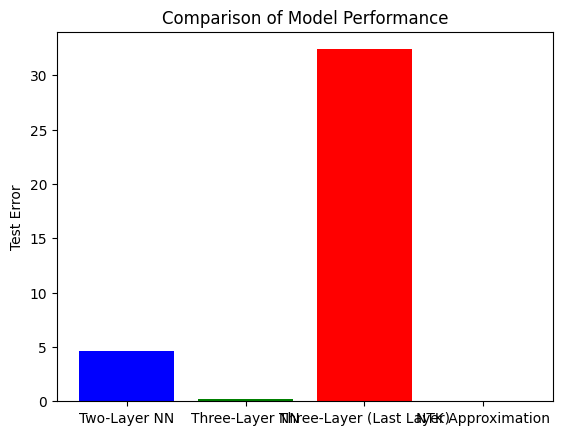

In [10]:
def main_experiment(N=1000, hidden_dim1=200, hidden_dim2=100, epochs=1000):
    x_train, y_train = generate_data(N)
    x_test, y_test = generate_data(N=200)

    # 2-Layer
    model_two_layer = TwoLayerNN(input_dim=4, hidden_dim=hidden_dim1)
    print("\nTraining Two-Layer Network...")
    train_network(model_two_layer, x_train, y_train, epochs=epochs)
    error_two_layer = evaluate_model(model_two_layer, x_test, y_test)

    # 3-Layer (full)
    model_three_layer = ThreeLayerNN(
        input_dim=4, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2
    )
    print("\nTraining Three-Layer Network...")
    train_network(model_three_layer, x_train, y_train, epochs=epochs)
    error_three_layer = evaluate_model(model_three_layer, x_test, y_test)

    # 3-Layer ( last)
    model_three_layer_last = ThreeLayerLastOnly(
        input_dim=4, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2
    )
    print("\nTraining Three-Layer (Last Layer Only)...")
    train_network(model_three_layer_last, x_train, y_train, epochs=epochs)
    error_three_layer_last = evaluate_model(model_three_layer_last, x_test, y_test)

    # NTK
    # print("\nTraining NTK Approximation Model...")
    # ntk_model = train_ntk_model(model_three_layer, x_train, y_train, epochs=epochs)
    # error_ntk = evaluate_model(
    #     lambda x: ntk_model(model_three_layer(x)), x_test, y_test
    # )
    error_ntk = 0

    results = {
        "Two-Layer NN": error_two_layer,
        "Three-Layer NN": error_three_layer,
        "Three-Layer (Last Layer)": error_three_layer_last,
        "NTK Approximation": error_ntk,
    }

    for model, err in results.items():
        print(f"{model}: Test Error = {err:.4f}")

    plt.bar(results.keys(), results.values(), color=["blue", "green", "red", "purple"])
    plt.ylabel("Test Error")
    plt.title("Comparison of Model Performance")
    plt.show()


main_experiment()

In [15]:
def compare_models_with_samples(N_list, hidden_dim1=200, hidden_dim2=100, epochs=500):
    results = {
        "2-Layer": [],
        "3-Layer": [],
        "3-Layer (Last)": [],
    }

    for N in N_list:
        print(f"\nTraining with N = {N}")
        x_train, y_train = generate_data(N)
        x_test, y_test = generate_data(200)

        # Two-layer model
        model_two_layer = TwoLayerNN(input_dim=4, hidden_dim=hidden_dim1)
        train_network(model_two_layer, x_train, y_train, epochs=epochs)
        results["2-Layer"].append(evaluate_model(model_two_layer, x_test, y_test))

        # 3-layer model
        model_three_layer = ThreeLayerNN(
            input_dim=4, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2
        )
        train_network(model_three_layer, x_train, y_train, epochs=epochs)
        results["3-Layer"].append(evaluate_model(model_three_layer, x_test, y_test))

        # 3-layer last-layer-only model
        model_three_layer_last = ThreeLayerLastOnly(
            input_dim=4, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2
        )
        train_network(model_three_layer_last, x_train, y_train, epochs=epochs)
        results["3-Layer (Last)"].append(
            evaluate_model(model_three_layer_last, x_test, y_test)
        )

    return results

In [ ]:
N_list = [200, 500, 1000, 2000, 5000, 10000]
results = compare_models_with_samples(
    N_list=N_list, hidden_dim1=200, hidden_dim2=100, epochs=500
)


Training with N = 200
Epoch 0/500, Loss: 33.9330
Epoch 100/500, Loss: 22.9958
Epoch 200/500, Loss: 35.5250
Epoch 300/500, Loss: 40.0615
Epoch 400/500, Loss: 22.3052
Epoch 0/500, Loss: 32.6740
Epoch 100/500, Loss: 20.0361
Epoch 200/500, Loss: 6.9575
Epoch 300/500, Loss: 1.0672
Epoch 400/500, Loss: 0.9823
Epoch 0/500, Loss: 28.6759
Epoch 100/500, Loss: 25.1795
Epoch 200/500, Loss: 50.5965
Epoch 300/500, Loss: 41.3161
Epoch 400/500, Loss: 41.7196

Training with N = 500
Epoch 0/500, Loss: 21.3011
Epoch 100/500, Loss: 21.3483
Epoch 200/500, Loss: 29.1710
Epoch 300/500, Loss: 9.4991
Epoch 400/500, Loss: 14.8845
Epoch 0/500, Loss: 37.5394
Epoch 100/500, Loss: 2.7941
Epoch 200/500, Loss: 1.2705
Epoch 300/500, Loss: 0.5995
Epoch 400/500, Loss: 3.0252
Epoch 0/500, Loss: 20.5783
Epoch 100/500, Loss: 34.9348
Epoch 200/500, Loss: 24.9198
Epoch 300/500, Loss: 34.3634
Epoch 400/500, Loss: 28.7954

Training with N = 1000
Epoch 0/500, Loss: 35.5422
Epoch 100/500, Loss: 26.9990
Epoch 200/500, Loss: 5.7

In [37]:
def log_formatter(val, _):
    if val < 1:
        return f"{val:.1}"
    elif val.is_integer():
        return f"{int(val)}"
    else:
        return f"{val:.2f}"

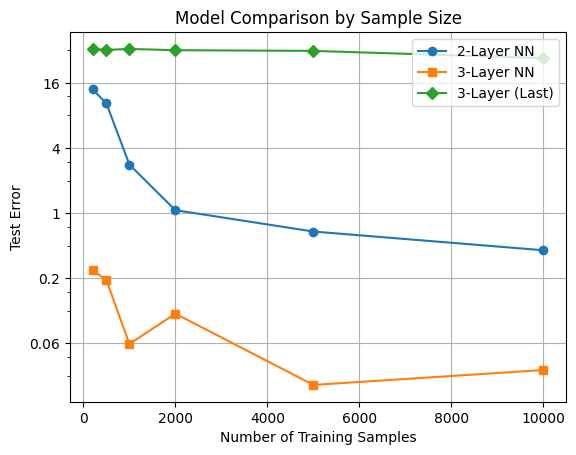

In [36]:
# Plot results
markers = ["o", "s", "D", "^"]
for model, errors in results.items():
    plt.plot(N_list, errors, label=model, marker=markers.pop(0))
import matplotlib.ticker as ticker

plt.xlabel("Number of Training Samples")
plt.ylabel("Test Error")
plt.title("Model Comparison by Sample Size")
plt.legend()
plt.yscale("log", base=4)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))
plt.grid()
plt.show()

In [38]:
# Compare models based on number of neurons
def compare_models_with_neurons(neuron_list, N=1000, epochs=500):
    results = {
        "2-Layer": [],
        "3-Layer": [],
        "3-Layer (Last)": [],
    }

    x_train, y_train = generate_data(N)
    x_test, y_test = generate_data(200)

    for neurons in neuron_list:
        print(f"\nTraining with hidden neurons = {neurons}")

        # Two-layer model
        model_two_layer = TwoLayerNN(input_dim=4, hidden_dim=neurons)
        train_network(model_two_layer, x_train, y_train, epochs=epochs)
        results["2-Layer"].append(evaluate_model(model_two_layer, x_test, y_test))

        # Three-layer model
        model_three_layer = ThreeLayerNN(
            input_dim=4, hidden_dim1=neurons, hidden_dim2=neurons // 2
        )
        train_network(model_three_layer, x_train, y_train, epochs=epochs)
        results["3-Layer"].append(evaluate_model(model_three_layer, x_test, y_test))

        # Three-layer last-layer-only model
        model_three_layer_last = ThreeLayerLastOnly(
            input_dim=4, hidden_dim1=neurons, hidden_dim2=neurons // 2
        )
        train_network(model_three_layer_last, x_train, y_train, epochs=epochs)
        results["3-Layer (Last)"].append(
            evaluate_model(model_three_layer_last, x_test, y_test)
        )

    return results

In [ ]:
neuron_list = [
    100,
    200,
    500,
    1000,
    2000,
    5000,
    10000,
    20000,
    50000,
    100000,
    200000,
    500000,
    1000000,
]
results_m = compare_models_with_neurons(neuron_list=neuron_list, N=1000, epochs=500)


Training with hidden neurons = 50
Epoch 0/500, Loss: 55.2754
Epoch 100/500, Loss: 36.0294
Epoch 200/500, Loss: 13.1370
Epoch 300/500, Loss: 6.9089
Epoch 400/500, Loss: 50.1129
Epoch 0/500, Loss: 25.1821
Epoch 100/500, Loss: 2.2314
Epoch 200/500, Loss: 0.9246
Epoch 300/500, Loss: 1.1002
Epoch 400/500, Loss: 0.4415
Epoch 0/500, Loss: 28.6347
Epoch 100/500, Loss: 29.5434
Epoch 200/500, Loss: 32.9227
Epoch 300/500, Loss: 28.3087
Epoch 400/500, Loss: 26.6409

Training with hidden neurons = 100
Epoch 0/500, Loss: 27.4210
Epoch 100/500, Loss: 23.6920
Epoch 200/500, Loss: 4.1548
Epoch 300/500, Loss: 5.3375
Epoch 400/500, Loss: 5.0476
Epoch 0/500, Loss: 12.1659
Epoch 100/500, Loss: 2.2123
Epoch 200/500, Loss: 0.4762
Epoch 300/500, Loss: 0.1181
Epoch 400/500, Loss: 0.2036
Epoch 0/500, Loss: 28.7451
Epoch 100/500, Loss: 37.1363
Epoch 200/500, Loss: 35.1969
Epoch 300/500, Loss: 40.1801
Epoch 400/500, Loss: 53.7765

Training with hidden neurons = 200
Epoch 0/500, Loss: 20.4139
Epoch 100/500, Loss:

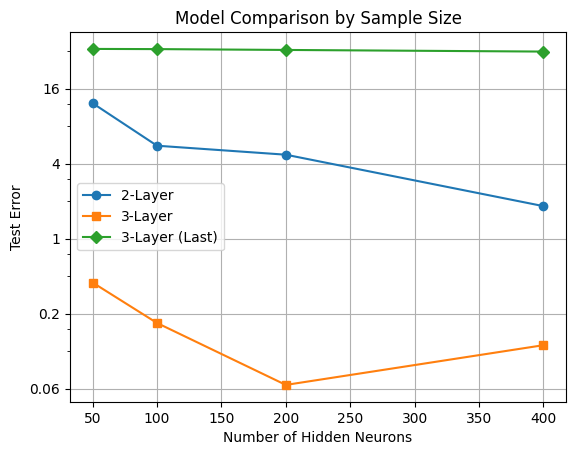

In [41]:
# Plot results
markers = ["o", "s", "D", "^"]
for model, errors in results_m.items():
    plt.plot(neuron_list, errors, label=model, marker=markers.pop(0))
import matplotlib.ticker as ticker

plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Test Error")
plt.title("Model Comparison by Sample Size")
plt.legend()
plt.yscale("log", base=4)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))
plt.grid()
plt.show()